# Python analysis

In [1]:
#import scipy as sp
import numpy as np
import xarray
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import logging
import seaborn
import pandas as pd
import pymc3 as pm
from pandas.api.types import CategoricalDtype
import copy
# import funcs
from analysis_funcs import *
# house keeping

In [2]:
# read in spectral measurement files
# NOTE: removing or renaming files in these subdirs will
# affect results

spec_dirs = ['Filters',
 'ChamberMeasurements',
 'LeafMeasurements',
 'InsectPhotoreceptors',
 'SolarSpectra']

spx = []
for _dir in spec_dirs:
    spx += read_spectra(os.path.join('python_data',_dir))
    
# read in field data
df_field = pd.read_csv('python_data/ExperimentalData/Aph2.csv')

# code categorical variables
df_field['Cultivar'] = pd.cut(df_field.Cultivar,[0,1,2],labels=['Derby Day', 'Volta'])
df_field['LT'] = pd.cut(df_field.LT,[0,1,2,4],labels=['UV-opaque','Standard','UV-transparent'])
# re-order with UV-transparent first
cat_type = CategoricalDtype(categories=['UV-transparent','Standard','UV-opaque'],ordered=True)
df_field['LT'] = df_field.LT.astype(cat_type)

# generate a summary table
summary = {'N':df_field.groupby(['LT','Cultivar']).count().Tunnel,
           'Total (Mean':df_field.groupby(['LT','Cultivar']).mean().plant_total,
           '+/- S.E.) ':df_field.groupby(['LT','Cultivar']).sem().plant_total,
           'Exposed (Mean':df_field.groupby(['LT','Cultivar']).mean().exposed,
           '+/- S.E.)':df_field.groupby(['LT','Cultivar']).sem().exposed
          }
tname = 'tables/t1_total_summary.tex'
pd.DataFrame(summary).to_latex(tname,float_format=lambda x: '{:.1f}'.format(x))

## Field Experiment Analysis

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, LT[T.UV-opaque], LT[T.Standard], Cultivar[T.Volta], Intercept]
Sampling 2 chains: 100%|██████████| 9600/9600 [00:09<00:00, 1027.41draws/s]
/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, LT[T.UV-opaque], LT[T.Standard], Cultivar[T.Volta], Intercept]
Sampling 2 chains: 100%|██████████| 9600/9600 [00:09<00:00, 1045.59draws/s]
/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  a

Exposed:
UVO ~ 230% change
Standard ~ 74% change
Volta ~ 47% change


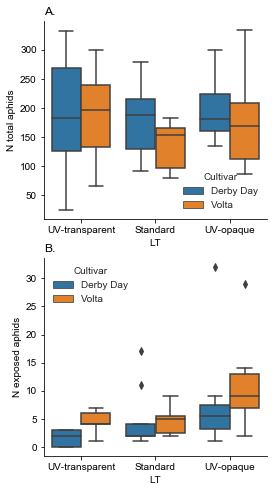

In [3]:
with pm.Model() as model_total:
    pm.glm.GLM.from_formula('plant_total~Cultivar+LT',
                            df_field,
                            family=pm.glm.families.NegativeBinomial())
    trace_total = pm.sample(4000, tune=800, init='adapt_diag',progressbar=True)

tname = 'tables/t2_total_model.tex'
pm.summary(trace_total).to_latex(tname,float_format=lambda x: '{:.3f}'.format(x))

with pm.Model() as model_exposed:
    pm.glm.GLM.from_formula('exposed~Cultivar+LT',
                            df_field,
                            family=pm.glm.families.NegativeBinomial())
    trace_exposed = pm.sample(4000, tune=800, init='adapt_diag',progressbar=True)

tname = 'tables/t3_exposed_model.tex'
pm.summary(trace_exposed).to_latex(tname,float_format=lambda x: '{:.3f}'.format(x))

# # No effects plot for final
# plt.style.use('seaborn-white')
# included_vars = [x for x in trace_exposed.varnames if x.find('mu') <0]
# included_vars = [x for x in included_vars if x.find('alpha') <0]
# pm.forestplot(trace_exposed,figsize=(4,2),combined=True,colors='k',var_names=included_vars,credible_interval=.95)
# plt.vlines(x=0,ymin=-1,ymax=100,colors='gray')

# # No effects plot for final
# plt.style.use('seaborn-white')
# included_vars = [x for x in trace_GR.varnames if x.find('mu') <0]
# included_vars = [x for x in included_vars if x.find('alpha') <0]
# pm.forestplot(trace_GR,figsize=(4,2),combined=True,colors='k',var_names=included_vars,credible_interval=.95)
# plt.vlines(x=0,ymin=-1,ymax=100,colors='gray')

# Effects plots
# plt.style.use('seaborn-white')
# plt.savefig('figures/f3_effects_plot.png',dpi=200)

# Figures
fig, ax = plt.subplots(nrows=2,figsize=(4,8))
plt.style.use('seaborn-white')
seaborn.despine()
g = seaborn.boxplot(y='plant_total',x='LT',hue='Cultivar',
                    data=df_field,ax=ax[0])
g.set_title('A.',loc='left')
g.set_ylabel('N total aphids')
g = seaborn.boxplot(y='exposed',x='LT',hue='Cultivar',
                     data=df_field,ax=ax[1],)
g.set_ylabel('N exposed aphids')
g.set_title('B.',loc='left')
fig.savefig('figures/f2_experiment1.png',dpi=200)
print('Exposed:')
print('UVO ~ {:.0f}% change'.format(compare(.859,.859+1.192466)))
print('Standard ~ {:.0f}% change'.format(compare(.859,.859+0.554187	)))
print('Volta ~ {:.0f}% change'.format(compare(.859,.859+0.384188)))

## Photoreceptor Responses
- Estimate photoreceptor responses for field experiment and lab experiment
- Generate colour coordinate plots

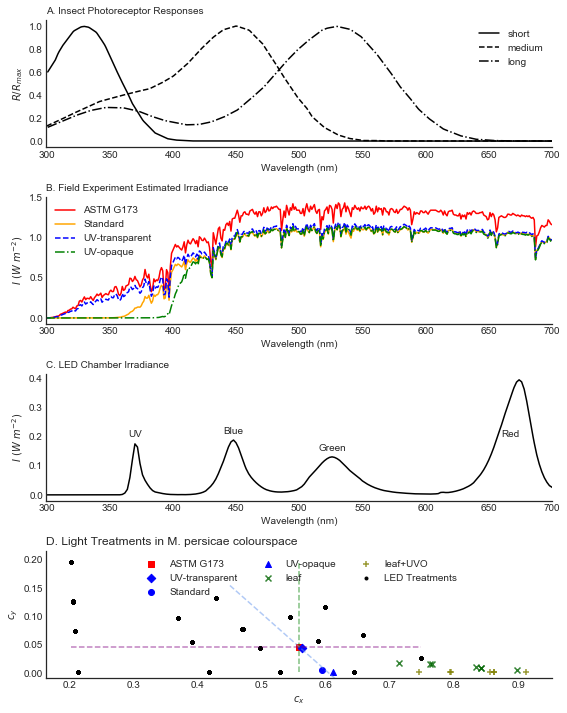

In [19]:
plt.style.use('seaborn-white')

photoreceptors = [spx[27],spx[29],spx[28]]
# insect response for solar spectrum
sunlight, _ = p_response(spx[30],photoreceptors)

# insect response for solar spectrum filtered by polythene
STD, _ = p_response(spx[0]*spx[30],photoreceptors)
UVT, _ = p_response(spx[1]*spx[30],photoreceptors)
UVO, _ = p_response(spx[2]*spx[30],photoreceptors)

# leaf transmission measurements
leaf = [x for x in spx if x.attrs['spectrum_type']=='LeafMeasurements']
# indexes of 100% reference
refs = [1,2,3,10,11,14,17]
# indexes of measured spectra
measured = [0,4,7,8,9,13,15]
# calculate mean 100%
ref_mean = 0
for x in refs:
    ref_mean += leaf[x]
ref_mean/=len(refs)
# calculate transmittance
leaf_transmittance = [leaf[x]/ref_mean for x in measured]
leaf_response = [p_response(x*spx[30],photoreceptors)[0] for x in leaf_transmittance]
leaf_response_uvo = [p_response(x*spx[30]*spx[2],photoreceptors)[0] for x in leaf_transmittance]
leaf_r_mean = np.mean(leaf_response,axis=0)

# # plot some example spectra
# f = plt.figure(figsize=(8,6))

# f.add_subplot(231)
# response_barplot(sunlight,'A. ASTM G173')
# plt.xticks([])
# plt.xlabel('')
# f.add_subplot(232)
# response_barplot(STD,'B. Standard')
# plt.xticks([])
# plt.xlabel('')

# f.add_subplot(233)
# response_barplot(UVT,'C. UV-transparent')
# plt.xticks([])
# plt.xlabel('')

# f.add_subplot(234)
# response_barplot(UVO,'D. UV-opaque')

# f.add_subplot(235)
# pwm = [255,60,0,120]

# out, norm = pwm_to_normalized_response([pwm],[255,120,255,240],spx[5],
#                                        photoreceptors,1)

# response_barplot(out[0],'E. LED example: High UV')


# f.add_subplot(236)
# pwm = [0,120,255,240]

# out, norm = pwm_to_normalized_response([pwm],[255,120,255,240],spx[5],
#                                        photoreceptors,1)

# response_barplot(out[0],'F. LED example: Low UV')
# seaborn.despine()
# plt.tight_layout()
# plt.savefig('figures/f4_ExResponses.png',dpi=200)

# read summary results
# this is 1 line per aphid
df_lab = pd.read_csv('python_data/ExperimentalData/lab_summary1.csv')

# calculate visual responses from PWM values
pwm_all= df_lab.loc[:,'R.pwm':].loc[:,::-1]

out, norm = pwm_to_normalized_response(pwm_all.values,[255,120,255,240],spx[5],
                                       photoreceptors,1)

for i,cname in enumerate(['R_short','R_mid','R_long']):
    df_lab[cname] = out[:,i]
    
# Calculate colour space
df_lab['Amplitude'] = (df_lab.Blue+df_lab.UV+df_lab.Green)

df_lab['cx'] = df_lab.Green/df_lab.Amplitude
df_lab['cy'] = df_lab.UV/df_lab.Amplitude

# Generate the pwm output table
pwm_vals = ((df_lab.groupby('treatment').mean()[['G.pwm','B.pwm','U.pwm']]/255)*100).astype(int)
pwm_vals.columns = ['G %','B %','UV %']
pwm_vals['Amplitude'] = df_lab.groupby('treatment').mean().Amplitude
pwm_vals['cx'] = df_lab.groupby('treatment').mean().cx
pwm_vals['cy'] = df_lab.groupby('treatment').mean().cy
pwm_vals['N'] = df_lab.groupby('treatment').count().ID
pwm_vals.index = np.arange(1,len(pwm_vals)+1)


pwm_vals.to_latex(buf='tables/t4_pwm.tex',index_names=False)

# calculate coordinates for some arbitrary spectra (sunlight through polythenes, leaves)
# dictionary for plotting
arbitrary_spectra_cxcy = [
    {'x':sunlight[2]/sunlight.sum(),
     'y':sunlight[0]/sunlight.sum(),
     'marker':'s',
     'label':'ASTM G173',
      'color':'r'},
    {'x':UVT[2]/UVT.sum(),
     'y':UVT[0]/UVT.sum(),
     'marker':'D',
     'label':'UV-transparent',
      'color':'b'},
    {'x':STD[2]/STD.sum(),
     'y':STD[0]/STD.sum(),
     'marker':'o',
     'label':'Standard',
      'color':'b'},
    {'x':UVO[2]/UVO.sum(),
     'y':UVO[0]/UVO.sum(),
     'marker':'^',
     'label':'UV-opaque',
      'color':'b'},
]
# add a separate entry for each leaf
for i,r in enumerate(leaf_response):
    dict_ = {'x':r[2]/r.sum(),
             'y':r[0]/r.sum(),
             'marker':'x',
             'color':'darkgreen',
             'alpha':.8}
    if i == 0:
        dict_['label'] = 'leaf'
    arbitrary_spectra_cxcy.append(dict_)
    
# add a separate entry for each leaf
for i,r in enumerate(leaf_response_uvo):
    dict_ = {'x':r[2]/r.sum(),
             'y':r[0]/r.sum(),
             'marker':'+',
             'color':'olive',
             'alpha':.8}
    if i == 0:
        dict_['label'] = 'leaf+UVO'
    arbitrary_spectra_cxcy.append(dict_)

# convenient dict for plotting arbitrary points into the cx cy space

plt.style.use('seaborn-white')

fig = plt.figure(figsize = (8,10))

ax = fig.add_subplot(411)
plt.plot(spx[27].coords['wavelength'],spx[27].values,c='k',label='short')
plt.plot(spx[29].coords['wavelength'],spx[29].values,c='k',linestyle='--',label='medium')
plt.plot(spx[28].coords['wavelength'],spx[28].values,c='k',linestyle='-.',label='long')
plt.legend()

plt.xlim(300,700)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$R/R_{max}$')
plt.text(0,1.05,'A. Insect Photoreceptor Responses',transform=ax.transAxes)

ax = fig.add_subplot(412)
(spx[30]).plot(color='r',label= 'ASTM G173')
plt.xlim(300,700)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$I~(W~m^{-2})$')
#plt.text(0,1.05,'B. ASTM G173 Model Solar Irradiance',transform=ax.transAxes)

plt.plot(spx[0].coords['wavelength'],(spx[0]*spx[30]).values,c='orange',label='Standard')
plt.plot(spx[1].coords['wavelength'],(spx[1]*spx[30]).values,c='b',linestyle='--',label='UV-transparent')
plt.plot(spx[2].coords['wavelength'],(spx[2]*spx[30]).values,c='g',linestyle='-.',label='UV-opaque')
plt.legend()
plt.xlim(300,700)
plt.ylabel(r'$I~(W~m^{-2})$')
plt.text(0,1.05,'B. Field Experiment Estimated Irradiance',transform=ax.transAxes)
plt.xlabel('Wavelength (nm)')

ax = fig.add_subplot(413)
spx[5].fillna(0).plot(c='k')
# label peaks
plt.annotate('UV',(365,.2))
plt.annotate('Blue',(440,.21))
plt.annotate('Green',(515,.15))
plt.annotate('Red',(660,.2))
plt.xlim(300,700)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$I~(W~m^{-2})$')
plt.text(0,1.05,'C. LED Chamber Irradiance',transform=ax.transAxes)

ax = fig.add_subplot(414)

# plot a line for ASTM constant Green balance
plt.vlines(sunlight[2]/sunlight.sum(),
           ymin=df_lab.R_short.min(),
           ymax=df_lab.R_short.max(),
           colors='green',linestyle = '--',alpha=.5)

# plot a line for ASTM constant Green balance
plt.hlines(sunlight[0]/sunlight.sum(),
           xmin=df_lab.R_long.min(),
           xmax=df_lab.R_long.max(),
           colors='purple',linestyle = '--',alpha=.5)

# plot a line for ASTM constant blue balance
xx = np.linspace(.45,df_lab.R_long.max(),100)
yy = 1-(sunlight[1]/sunlight.sum())-xx
plt.plot(xx,yy,'cornflowerblue',linestyle = '--',alpha=.5)

# pt_size=200
# alpha=.6
# fcol = 'b'

plot_extras(arbitrary_spectra_cxcy)
# plot the data points
plt.scatter(df_lab.R_long,df_lab.R_short,c='k',marker='.',label='LED Treatments')
plt.legend(loc='upper center',ncol=3)
plt.xlabel(r'$c_x$')
plt.ylabel(r'$c_y$')
plt.title('D. Light Treatments in M. persicae colourspace',loc='left')
plt.ylim(df_lab.R_short.min()-.01,df_lab.R_short.max()*1.1)

seaborn.despine()
plt.tight_layout()

# save figure

plt.savefig('figures/f1_lightEnvs.png',dpi=200)

In [5]:
{'LED_max_irradiance':float(spx[5].fillna(0).integrate('wavelength')),
 'ASTM_irradiance':float(spx[30].fillna(0).integrate('wavelength'))}
 

{'LED_max_irradiance': 24.2861724842639, 'ASTM_irradiance': 863.2387121562393}

In [6]:
sunlight.sum()

278.7090601392953

## Analysis of Lab Experiment

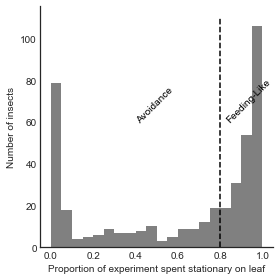

In [7]:
# code behaviours
coding_bins = [-.01,.8,1.01]
coding_labels = ["Avoidance", "Feeding-Like"]
plt.figure(figsize=(4,4))
plt.hist(df_lab.propSOL,histtype='bar',bins=20,color='gray')
plt.vlines(x=.8,ymin=0,ymax=110,linestyles='--',color='k')
plt.text(x=.4,y=60,s='Avoidance',color='k',rotation=45)
plt.text(x=.82,y=60,s='Feeding-Like',color='k',rotation=45)
plt.xlabel('Proportion of experiment spent stationary on leaf')
plt.ylabel('Number of insects')
seaborn.despine()
plt.tight_layout()
plt.savefig('figures/f6_hist.png',dpi=200)

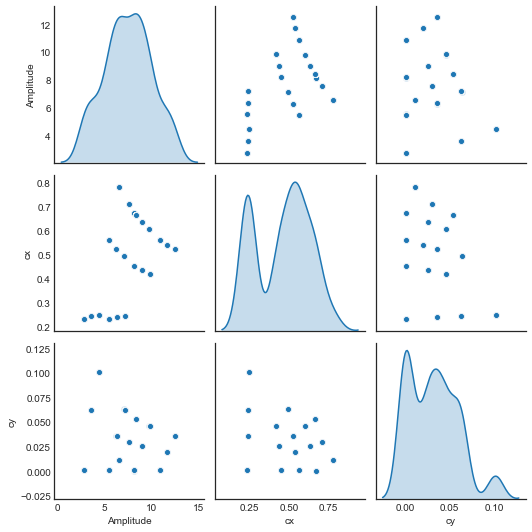

In [8]:
# generate a new binary response variable:
# arbitrary cut point of 0.8
# If insect spends more than 80% of experiment (~1 hour)
# in a non-feeding position, label as avoidance.
# If spends more than 50% label as feeding
df_lab['avoidance'] = df_lab.propSOL < .8
seaborn.pairplot(df_lab[['Amplitude','cx','cy']],diag_kind='kde')
plt.tight_layout()
plt.savefig('figures/f7_cornerplot.png',dpi=200)

In [9]:
models, traces = run_models(df_lab,generate_o3('avoidance','Amplitude','cx','cy'),nitt=5000,tune=1200)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Amplitude:cx, cx, Amplitude:cy, cy, Amplitude, Intercept]
Sampling 2 chains: 100%|██████████| 12400/12400 [01:26<00:00, 142.67draws/s]
The acceptance probability does not match the target. It is 0.8873628941043592, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cy, Amplitude:cx, cx, Amplitude, Intercept]
Sampling 2 chains: 100%|██████████| 12400/12400 [01:21<00:00, 151.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cx, Amplitude:cy, cy, Amplitude, Intercept]
Sampling 2 chains: 100%|██████████| 12400/124

In [10]:
# model comparison
models_dict = {}
for k, m in zip(models,traces):
    models_dict[k] = m
dfwaic = pm.compare(models_dict, ic='WAIC')
# sort by index
dfwaic.sort_index(inplace=True)
# add model formulae field
dfwaic['model_formulae'] = generate_o3('y','A','cx','cy',latex=True)
dfwaic.sort_values('WAIC',inplace=True)
dfwaic.drop(labels=['dWAIC','weight','dSE','var_warn'],axis=1).to_latex('tables/t5_model_comparison.tex',escape=False)
dfwaic

/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pymc3/stats.py:557: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn,model_formulae
8,560.94,3.15,0,0.55,10.54,0,0,$y \sim cx+cy$
5,562.49,4,1.55,0,10.51,0.78,0,$y \sim A+cx+cy$
11,562.89,2.08,1.95,0.32,9.72,4.1,0,$y \sim cy$
2,563.91,5.04,2.97,0,10.68,1.82,0,$y \sim (A*cy)+(cx)$
7,564.34,3.1,3.4,0,9.83,3.51,0,$y \sim A+cy$
1,564.41,5.1,3.47,0,10.69,1.31,0,$y \sim (A*cx)+(cy)$
0,565.56,6.06,4.61,0,10.84,2.34,0,$y \sim (A*cy)+(A*cx)$
4,565.71,4.09,4.77,0,9.96,3.87,0,$y \sim (A*cy)$
10,575.95,2.06,15.01,0.12,6.44,8.47,0,$y \sim cx$
6,577.61,3.06,16.67,0,6.61,8.49,0,$y \sim A+cx$


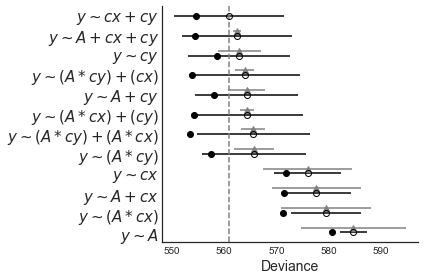

In [12]:
# Effect size plot for comparing models
pm.compareplot(dfwaic)
ax = plt.gca()
ys = ax.get_ylim()
plt.yticks(np.linspace(ys[0]+.04,ys[1]-.04,len(dfwaic))[::-1],dfwaic.model_formulae,size=15)
seaborn.despine()
plt.tight_layout()
plt.savefig('figures/f8_modcompare.png',dpi=200)

/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


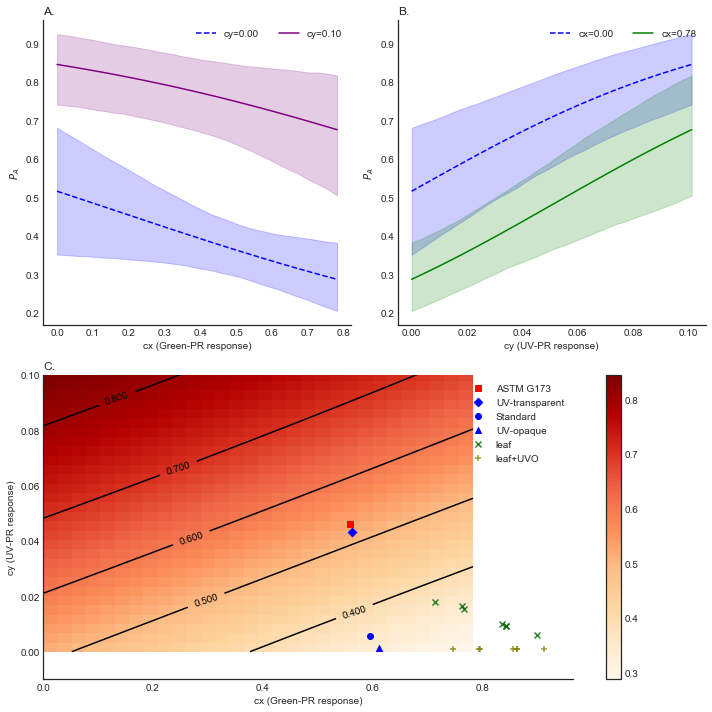

In [20]:
tname = 'tables/t6_best_model.tex'
pm.summary(traces[8]).to_latex(tname,float_format=lambda x: '{:.3f}'.format(x))

# Evaluate on an even cx_, cy_ grid
cx_ = np.linspace(0,df_lab.cx.max(),30)
cy_ = np.linspace(0,df_lab.cy.max(),30)
Amplitude_ = np.linspace(df_lab.Amplitude.min()*.8,df_lab.Amplitude.max(),30)

preds_5 = predict_from_trace(traces[5], {'cx':cx_,'cy':cy_,'Amplitude':Amplitude_})
preds_8 = predict_from_trace(traces[8], {'cx':cx_,'cy':cy_})
preds_11 = predict_from_trace(traces[11], {'cy':cy_})

fig = plt.figure(figsize=(10,10))

fig.add_subplot(221)

# 1D plot
mu, lwr, upr = estimate_1d(preds_8[0,:,:])
plt.fill_between(cx_,lwr,upr,alpha=.2,color='b')
plt.plot(cx_,mu,label='cy=0.00',linestyle='--',color='b')
mu, lwr, upr = estimate_1d(preds_8[-1,:,:])
plt.fill_between(cx_,lwr,upr,alpha=.2,color='purple')
plt.plot(cx_,mu,label='cy={:.2f}'.format(cy_.max()),color='purple')
plt.xlabel('cx (Green-PR response)')
plt.ylabel(r'$P_A$')
plt.legend(ncol=2)
plt.title('A.',loc='left')

fig.add_subplot(222)

# 1D plot
mu, lwr, upr = estimate_1d(preds_8[:,0,:])
plt.fill_between(cy_,lwr,upr,alpha=.2,color='b')
plt.plot(cy_,mu,label='cx=0.00',linestyle='--',color='b')
mu, lwr, upr = estimate_1d(preds_8[:,-1,:])
plt.fill_between(cy_,lwr,upr,alpha=.2,color='g')
plt.plot(cy_,mu,label='cx={:.2f}'.format(cx_.max()),color='g')
plt.xlabel('cy (UV-PR response)')
plt.ylabel(r'$P_A$')
plt.legend(ncol=2)
plt.title('B.',loc='left')

ax = fig.add_subplot(212)

# 2D plot
plot_cx_cy(preds_8,{'cx':cx_,'cy':cy_},ax=ax,alpha=1,cmap='OrRd')
plot_extras(arbitrary_spectra_cxcy)
plt.xlabel('cx (Green-PR response)')
plt.ylabel('cy (UV-PR response)')
plt.ylim(-.01,.1)
plt.legend(ncol=1)
plt.title('C.',loc='left')

# post matter
seaborn.despine()
plt.tight_layout()
plt.savefig('figures/f11_postpredictive.png',dpi=200)

In [33]:
# calculate means for leaves
leaf_mean = {}
leaf_mean['x'] = np.mean([s['x'] for s in arbitrary_spectra_cxcy if s['color']=='darkgreen'])
leaf_mean['y'] = np.mean([s['y'] for s in arbitrary_spectra_cxcy if s['color']=='darkgreen'])
leaf_mean['label'] = 'Leaf (mean)'

leaf0_mean = {}
leaf0_mean['x'] = np.mean([s['x'] for s in arbitrary_spectra_cxcy if s['color']=='olive'])
leaf0_mean['y'] = np.mean([s['y'] for s in arbitrary_spectra_cxcy if s['color']=='olive'])
leaf0_mean['label'] = 'Leaf + UV-opaque (mean)'

# coefficients from best model
beta_0 = traces[8]['Intercept'].mean()
beta_1 = traces[8]['cx'].mean()
beta_2 = traces[8]['cy'].mean()

# responses for all arbitrary spectra
predictions = []
labels = []
i=0
j=0
for s in arbitrary_spectra_cxcy[:4]+[leaf_mean,leaf0_mean]:
    y_logit = beta_0 + (beta_1*s['x']) + (beta_2*s['y'])
    predictions.append(np.exp(y_logit)/(1+np.exp(y_logit)))
    labels.append(s['label'])

# save to file
tname = 'tables/t7_additional.tex'
pd.DataFrame({'Light Environment':labels,'$P_A$':predictions}).to_latex(tname,float_format=lambda x: '{:.2f}'.format(x))